# Semantic Segmentation using Unet

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_filenames = os.listdir(os.path.join(data_dir, 'org'))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.data_dir, 'org', img_name)
        mask_path = os.path.join(self.data_dir, 'label', img_name)

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Set your dataset directory
data_dir = '/kaggle/input/minijsrtsegmentation/dataset/Segmentation01/train'

# Create dataset and dataloader
dataset = SemanticSegmentationDataset(data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [4]:
""" Parts of the U-Net model """

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [5]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [6]:
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [7]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm


model = UNet(n_channels=3, n_classes=1, bilinear=False)
# optimizer = optim.RMSprop(model.parameters(),
                              # lr=1e-5, weight_decay=1e-8, momentum=0.999, foreach=True)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
model.to(device="cuda")


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [8]:
epochs=20
n_train=50
device="cuda"
gradient_clipping=1.0
global_step=0
dir_checkpoint = Path('./checkpoints/')

for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            images, true_masks = batch[0], batch[1]

            images = images.to(device=device)
            true_masks = true_masks.to(device=device)

            optimizer.zero_grad()
            with torch.autocast(device if device != 'mps' else 'cuda', enabled=False):
                masks_pred = model(images)
                if model.n_classes == 1:
                    loss = criterion(masks_pred, true_masks)
                    # print(F.sigmoid(masks_pred).size())
                    # print(true_masks.size())
                    loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.squeeze(1).float(), multiclass=False)
                else:
                    loss = criterion(masks_pred, true_masks)

            loss.backward()
            optimizer.step()


            global_step += 1
            epoch_loss += loss.item()
        print(epoch_loss)

Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
state_dict = model.state_dict()
#state_dict['mask_values'] = dataset.mask_values
torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
logging.info(f'Checkpoint {epoch} saved!')

12.099852085113525
7.751219034194946
6.446779429912567
6.1045472621917725
6.083368122577667
5.719977021217346
5.453354120254517
5.168240517377853
5.0897659957408905
4.940114319324493
4.709349662065506
4.585970520973206
4.570695996284485
4.4892096519470215
4.298672646284103
4.1814896166324615
4.050613075494766
3.9746254086494446
3.810125395655632
3.71886844933033


In [9]:
Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
state_dict = model.state_dict()
#state_dict['mask_values'] = dataset.mask_values
torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
logging.info(f'Checkpoint {epoch} saved!')

In [10]:
import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm


def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)


def unique_mask_values(idx, mask_dir, mask_suffix):
    mask_file = list(mask_dir.glob(idx + mask_suffix + '.*'))[0]
    mask = np.asarray(load_image(mask_file))
    if mask.ndim == 2:
        return np.unique(mask)
    elif mask.ndim == 3:
        mask = mask.reshape(-1, mask.shape[-1])
        return np.unique(mask, axis=0)
    else:
        raise ValueError(f'Loaded masks should have 2 or 3 dimensions, found {mask.ndim}')


class BasicDataset(Dataset):
    def __init__(self, images_dir: str, mask_dir: str, scale: float = 1.0, mask_suffix: str = ''):
        self.images_dir = Path(images_dir)
        self.mask_dir = Path(mask_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if isfile(join(images_dir, file)) and not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')

        logging.info(f'Creating dataset with {len(self.ids)} examples')
        logging.info('Scanning mask files to determine unique values')
        with Pool() as p:
            unique = list(tqdm(
                p.imap(partial(unique_mask_values, mask_dir=self.mask_dir, mask_suffix=self.mask_suffix), self.ids),
                total=len(self.ids)
            ))

        self.mask_values = list(sorted(np.unique(np.concatenate(unique), axis=0).tolist()))
        logging.info(f'Unique mask values: {self.mask_values}')

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(mask_values, pil_img, scale, is_mask):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img = np.asarray(pil_img)

        if is_mask:
            mask = np.zeros((newH, newW), dtype=np.int64)
            for i, v in enumerate(mask_values):
                if img.ndim == 2:
                    mask[img == v] = i
                else:
                    mask[(img == v).all(-1)] = i

            return mask

        else:
            if img.ndim == 2:
                img = img[np.newaxis, ...]
            else:
                img = img.transpose((2, 0, 1))

            if (img > 1).any():
                img = img / 255.0

            return img

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.mask_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))

        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        mask = load_image(mask_file[0])
        img = load_image(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(self.mask_values, img, self.scale, is_mask=False)
        mask = self.preprocess(self.mask_values, mask, self.scale, is_mask=True)

        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous()
        }


class CarvanaDataset(BasicDataset):
    def __init__(self, images_dir, mask_dir, scale=1):
        super().__init__(images_dir, mask_dir, scale, mask_suffix='_mask')

import matplotlib.pyplot as plt


def plot_img_and_mask(img, mask):
    classes = mask.max() + 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    for i in range(classes):
        ax[i + 1].set_title(f'Mask (class {i + 1})')
        ax[i + 1].imshow(mask == i)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [11]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms





def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold

    return mask[0].long().squeeze().numpy()


"""def get_args():
    parser = argparse.ArgumentParser(description='Predict masks from input images')
    parser.add_argument('--model', '-m', default='MODEL.pth', metavar='FILE',
                        help='Specify the file in which the model is stored')
    parser.add_argument('--output', '-o', metavar='OUTPUT', nargs='+', help='Filenames of output images')
    parser.add_argument('--viz', '-v', action='store_true',
                        help='Visualize the images as they are processed')
    parser.add_argument('--no-save', '-n', action='store_true', help='Do not save the output masks')
    parser.add_argument('--mask-threshold', '-t', type=float, default=0.5,
                        help='Minimum probability value to consider a mask pixel white')
    parser.add_argument('--scale', '-s', type=float, default=0.5,
                        help='Scale factor for the input images')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')
    parser.add_argument('--classes', '-c', type=int, default=2, help='Number of classes')

    return parser.parse_args()"""


def get_output_filenames(args):
    def _generate_name(fn):
        return f'{os.path.splitext(fn)[0]}_OUT.png'

    return args.output or list(map(_generate_name, args.input))


def mask_to_image(mask: np.ndarray, mask_values):
    if isinstance(mask_values[0], list):
        out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
    elif mask_values == [0, 1]:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
    else:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

    if mask.ndim == 3:
        mask = np.argmax(mask, axis=0)

    for i, v in enumerate(mask_values):
        out[mask == i] = v

    return Image.fromarray(out)


if __name__ == '__main__':


    #out_files = get_output_filenames(args)

    net = model

    device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

    net.to(device=device)
    #state_dict = torch.load(args.model, map_location=device)
    #mask_values = state_dict.pop('mask_values', [0, 1])
    #net.load_state_dict(state_dict)


    img = Image.open("/kaggle/input/minijsrtsegmentation/dataset/Segmentation01/train/org/1.png").convert("RGB")

    mask = predict_img(net=net,
                        full_img=img,
                        scale_factor=0.5,
                        out_threshold=0.5,
                        device=device)


    out_filename = "/kaggle/working/out.png"
    result = mask_to_image(mask, [0,1])
    result.save(out_filename)


In [12]:
!mkdir output

In [13]:
for i in range(10):
    img = Image.open("/kaggle/input/minijsrtsegmentation/dataset/Segmentation01/test/org/"+str(i)+".png").convert("RGB")

    mask = predict_img(net=net,
                        full_img=img,
                        scale_factor=0.5,
                        out_threshold=0.5,
                        device=device)


    out_filename = "/kaggle/working/output/"+str(i)+".png"
    result = mask_to_image(mask, [0,1])
    result.save(out_filename)

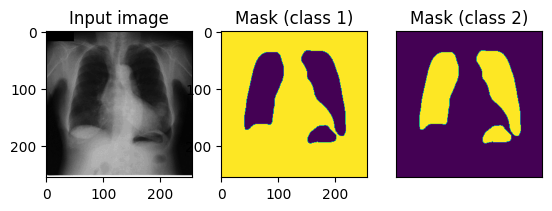

In [14]:
img = Image.open("/kaggle/input/minijsrtsegmentation/dataset/Segmentation01/train/org/1.png").convert("RGB")
mask = predict_img(net=net,
                        full_img=img,
                        scale_factor=0.5,
                        out_threshold=0.5,
                        device=device)
result = mask_to_image(mask, [0,1])
plot_img_and_mask(img, mask)